In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import imghdr

2025-07-15 17:09:29.525957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 17:09:29.526568: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-15 17:09:29.532122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-15 17:09:29.540021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752599369.553174    1552 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752599369.55

In [3]:
import cv2

In [4]:
data_dir = "data"
image_extensions = ["jpeg", "jpg", "bmp", "png"] #List of allowed extensions

In [5]:
os.listdir(data_dir)

['horse', 'dog', 'butterfly', 'cat']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Loading our data

In [7]:
data = tf.keras.utils.image_dataset_from_directory("data")
#Builds us the dataset and does some preprocessing

Found 257 files belonging to 4 classes.


2025-07-15 17:09:31.897632: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
#The data is a generator so we will convert it to a numpy iterator
data_iterator = data.as_numpy_iterator()

#We will get consecutive batches from .next()

In [9]:
batch = data_iterator.next()
batch

(array([[[[223.11133   , 241.03711   , 193.        ],
          [226.22266   , 242.33398   , 192.77734   ],
          [228.74219   , 245.3711    , 190.44336   ],
          ...,
          [152.55664   , 163.51562   , 155.18555   ],
          [156.44336   , 169.44336   , 159.44336   ],
          [162.77734   , 175.77734   , 165.77734   ]],
 
         [[224.23462   , 242.18164   , 191.83423   ],
          [226.79492   , 243.47852   , 191.12425   ],
          [229.10208   , 246.30325   , 189.19264   ],
          ...,
          [153.27644   , 164.23543   , 155.90535   ],
          [157.58789   , 170.58789   , 160.58789   ],
          [163.92188   , 176.92188   , 166.92188   ]],
 
         [[225.64844   , 243.89844   , 190.67578   ],
          [227.73294   , 245.09943   , 189.50568   ],
          [229.26456   , 246.89346   , 187.0561    ],
          ...,
          [152.89986   , 163.625     , 155.18839   ],
          [157.58203   , 170.29492   , 160.29492   ],
          [164.19247   , 176.90

In [10]:
len(batch) #the images and the labels


2

In [11]:
batch[0].shape #We have to index the 0 as we want the shape of the images batch[1] wil refer to the labels

(32, 256, 256, 3)

In [12]:
batch[1]

array([0, 3, 2, 3, 0, 3, 1, 3, 0, 2, 3, 2, 2, 3, 0, 2, 2, 1, 3, 3, 3, 0,
       0, 2, 0, 2, 3, 2, 2, 3, 2, 2], dtype=int32)

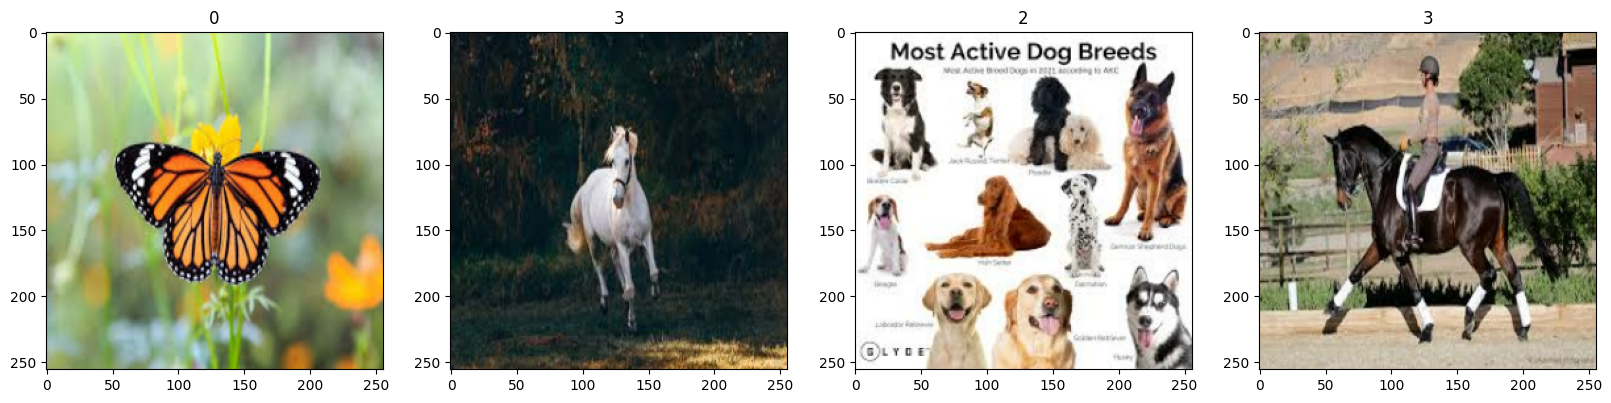

In [13]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing our data

In [14]:
data = data.map(lambda x,y: (x/tf.reduce_max(x), y))
#Every time we fetch our data from the pipeline, it will scale our data between 0 and 1

In [15]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [16]:
batch[0].max()

np.float32(1.0)

Splitting our data 

In [17]:
len(data) # no of batches

9

In [18]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2) + 1
test_size = int(len(data) * .1) + 1 #Adding a one so all batches are used

train_size, val_size, test_size

(6, 2, 1)

In [19]:
#Our data has already been shuffled so we aren't shuffling it here
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

In [20]:
len(train_data), len(val_data), len(test_data)

(6, 2, 1)

Building the deep learning model

In [21]:
model = tf.keras.Sequential()

In [22]:
#16 filters, kernal_size = (3,3) stride = 1, stride is how many pixels it moves over at once
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D()) #returns back the max value that we get from our convolution

model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

/home/varshaan/animal-image-classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile("adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
logdir = "logs"

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
history = model.fit(train_data, epochs = 15, validation_data= val_data, callbacks=[tensorboard_callback])

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.2859 - loss: 1.5393 - val_accuracy: 0.2656 - val_loss: 1.3105
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.3023 - loss: 1.2846 - val_accuracy: 0.5469 - val_loss: 1.2079
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5020 - loss: 1.1640 - val_accuracy: 0.5938 - val_loss: 1.0410
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.5868 - loss: 0.9763 - val_accuracy: 0.7188 - val_loss: 0.8013
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.7670 - loss: 0.6914 - val_accuracy: 0.7812 - val_loss: 0.6772
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.7566 - loss: 0.6470 - val_accuracy: 0.7344 - val_loss: 0.7594
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.7869 - loss: 0.6397 - val_accuracy: 0.7188 - val_loss: 0.6083
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.8144 - loss: 0.5753 - val_accuracy: 0.8438 - val_loss:

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

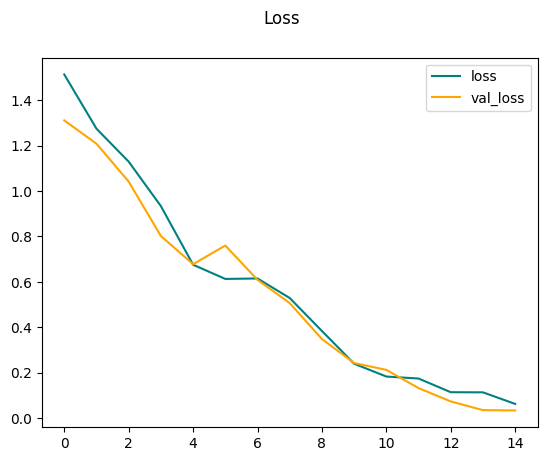

In [29]:
fig = plt.figure()
plt.plot(history.history["loss"], color="teal", label="loss")
plt.plot(history.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss")
plt.legend()
plt.show()

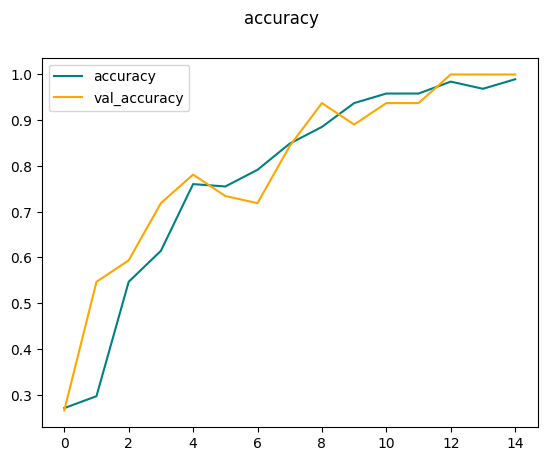

In [30]:
fig = plt.figure()
plt.plot(history.history["accuracy"], color="teal", label="accuracy")
plt.plot(history.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("accuracy")
plt.legend()
plt.show()

In [31]:
from tensorflow.keras.metrics import Precision, Recall

In [32]:
precision = Precision()
recall = Recall()

In [33]:
len(test_data)

1

In [34]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    precision.update_state(y, y_pred_classes)
    recall.update_state(y, y_pred_classes)

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


2025-07-15 17:09:55.242167: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
print("precision:", precision.result().numpy(), "recall", recall.result().numpy())

precision: 1.0 recall 1.0


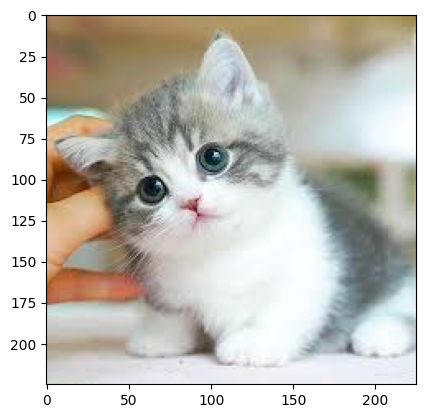

In [37]:
img = cv2.imread("images.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

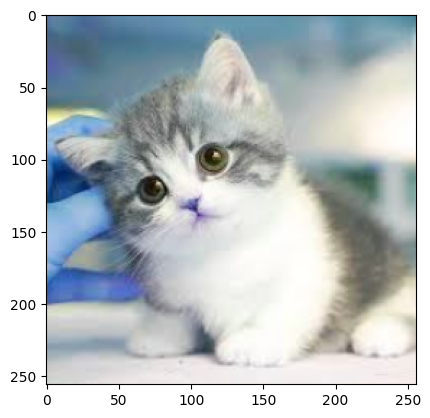

In [38]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize/255)

In [39]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [40]:
ans = list(y_pred[0]).index(max(list(y_pred[0])))
if ans == 0:
    print("Butterfly")
elif ans == 1:
    print("Cat")
elif ans == 2:
    print("dog")
elif ans == 3:
    print("horse")


Cat


In [41]:
y_pred

array([[1.3747722e-05, 9.4177294e-01, 5.6041285e-02, 2.1720151e-03]],
      dtype=float32)

In [42]:
print(y_pred)

[[1.3747722e-05 9.4177294e-01 5.6041285e-02 2.1720151e-03]]


Saving the model

In [43]:
model.save(os.path.join("models", "animalclassification.keras"))